## Telecom churn case study 

    - Using multivariant logistic regression 
    - Datasets are available in Datasets folder

### Steps:
    1. Data Preparation 
        a. Importing and Merging Data
        b. Inspecting the merged dataframe
        c. Data Preparation
        d. Checking Outliers
        e. Checking null values
    2. Train-Test split
    3. Feature Scaling
    4. Check data imbalance

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
#Import required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

- Dataset 1 - Churn Data

In [3]:
churn_data = pd.read_csv('datasets/churn_data.csv')

In [4]:
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


- Dataset 2 - custmomer data

In [5]:
customer_data = pd.read_csv('datasets/customer_data.csv')

In [6]:
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


- Dataset 3 - Internet Data

In [7]:
internet_data = pd.read_csv('datasets/internet_data.csv')

In [8]:
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


#### Summary
    - Customer ID is common key between all three datasets
    - Chrun_data - It has target varibale along with other variables.
    - Customer_data - It has few details about customers, like Gender, Senior Citizen , dependents etc.
    - Internrt_data - It was all options or services customer is using.

In [9]:
# Merge all datasets to create final single dataset with all required information.
tmp_df1 = pd.merge(churn_data, customer_data, how='inner', on = 'customerID')

In [10]:
tmp_df1.head() 

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No


In [11]:
telecom = pd.merge(tmp_df1, internet_data, how='inner', on='customerID')

In [12]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


- telecom dataframe is consolidated dataframe with all required information.

### Inspecting merged datafram

In [13]:
telecom.shape  #It has 7043 data points with 21 features including target variable.

(7043, 21)

In [14]:
#Lets check the statistical summary of dataset.
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


- This show statistical summary of 3 columns only, as out of 21 columns, only three columns are numeric in nature. And, we know statstic work on numerical varibales only not on categorical variable.  

In [15]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


- Info shows same,i.e, tenure,  MonthlyCharges and SeniorCitizen columns are numeric.
- Also, there are no columns with null value. 

#### Data Preparation 
- Converting columns with Yes/No to 1/0 

In [16]:
#Get columns with only Yes and No as values
pd.options.display.max_columns = None
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [17]:
telecom.nunique(axis=0)

customerID          7043
tenure                73
PhoneService           2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
dtype: int64

In [18]:
#Columns with just Yes/No values
col_names = ['PhoneService','PaperlessBilling','Churn','Partner','Dependents']

- Use lambda function to convert all Yes to 1 and No to 0
- Here we have not taken Senior Citizen as it is already in numeric form and Gender is Male/Female and not Yes/No

In [19]:
telecom[col_names] = telecom[col_names].apply(lambda x : x.map({'Yes': 1, 'No': 0}))

In [20]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0,No,Fiber optic,No,No,No,No,No,No


In [21]:
telecom.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [22]:
telecom.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [23]:
telecom.TechSupport.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

- For other categorical columns there are multiple values. 
- Hence, we will be using **Dummy Variable** method to convert categorical into Numeric

In [24]:
# Creating list of columns 
cols_dummy = ['Contract','PaymentMethod','InternetService','gender']

- Using pandas method get_dummies and dropping first variable afte conversion as it can be explained by other varibales

In [25]:
dummy_1 = pd.get_dummies(telecom[cols_dummy], drop_first=True)

In [26]:
dummy_1.head()

,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male
0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,1
2,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0,0


In [27]:
#Concatinating this with main dataset
telecom = pd.concat([telecom, dummy_1], axis=1)

In [28]:
telecom.head(2)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,0,0,0,1,0,0,0,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No,1,0,0,0,1,0,0,1


In [29]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   Contract                               7043 non-null   object 
 4   PaperlessBilling                       7043 non-null   int64  
 5   PaymentMethod                          7043 non-null   object 
 6   MonthlyCharges                         7043 non-null   float64
 7   TotalCharges                           7043 non-null   object 
 8   Churn                                  7043 non-null   int64  
 9   gender                                 7043 non-null   object 
 10  SeniorCitizen                          7043 non-null   int64  
 11  Part

- Focus on features which has Dtypes as objects.
- First 3, we have already converted to numeric using get_dummies method.
- Lets work on other pending features
- Excluding feature TotalCharges for now, it should be continuos.

In [30]:
# list of pending features 
dummy_2 = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
          'TechSupport','StreamingTV','StreamingMovies']

- Writing a function to convert categorical features into numeric using get_dummies 
- Also, by not dropping first column, instead column with longest length of its name

In [31]:
def dummies_drop_maxLen_col(lst : list, df) :
    """
    ****Prashik Bansod******
    Two arguments :
        1. List of columns names
        2. Pandas dataframe
    return : A dataframe with dummy variables without longest column name
    """
    for i in lst:
        i_tmp = pd.get_dummies(df[i],prefix=i)
        final_nm = {}
        for col_nm in i_tmp.columns:
            final_nm[col_nm] = len(col_nm)
        to_drop = max(final_nm, key=lambda x : final_nm[x])
        i_tmp = i_tmp.drop([to_drop], axis = 1)
        df = pd.concat([df,i_tmp], axis=1)
    return df
        

In [32]:
telecom = dummies_drop_maxLen_col(dummy_2, telecom)

In [33]:
telecom.head(2)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No,1,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0


In [36]:
# Drop features which we converted using get_dummies
dummy_set = cols_dummy + dummy_2

In [38]:
dummy_set #These are the columns we have to drop

['Contract',
 'PaymentMethod',
 'InternetService',
 'gender',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [39]:
telecom = telecom.drop(dummy_set, axis=1)

In [40]:
telecom.head(2)

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,0,56.95,1889.5,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0


In [41]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   object 
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

- Here we see 2 columns are still of type object:
    - customerID : not required as a feature for model. It is more of as an unique identifier 
    - TotalCharges : This should be continuos, lets impect this columns and change it to float

In [50]:
# pd.to_numeric(telecom.TotalCharges) -> using this we saw at index 488, it has empty string with one space.
## replacing it with 0 
telecom['TotalCharges'] = telecom['TotalCharges'].replace(' ',0)

In [53]:
#COnvert Dtype to numeric
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'])

In [54]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   float64
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

In [55]:
telecom.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

### Check outliers in continuous features

In [56]:
con_feat = ['tenure','MonthlyCharges','TotalCharges']

In [57]:
#Create tmp dataframe to check outliers 
tmp_df = telecom[con_feat]

In [58]:
tmp_df.head(2)

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50


In [61]:
tmp_df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


<AxesSubplot:>

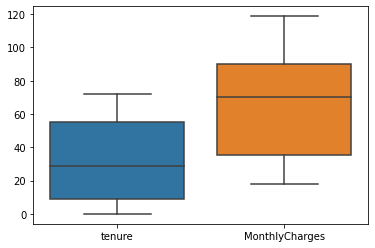

In [69]:
sns.boxplot(data=tmp_df[['tenure','MonthlyCharges']])

<AxesSubplot:xlabel='TotalCharges'>

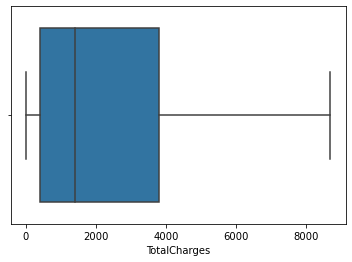

In [70]:
sns.boxplot(tmp_df.TotalCharges)

- We dont see any outliers

In [71]:
#### Handling null values 

In [76]:
telecom.isnull().sum()

customerID                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
Contract_One year                        0
Contract_Two year                        0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
InternetService_Fiber optic              0
InternetService_No                       0
gender_Male                              0
MultipleLines_No                         0
MultipleLines_Yes                        0
InternetService_DSL                      0
InternetService_No                       0
OnlineSecurity_No                        0
OnlineSecur

### Train Test Split

In [98]:
#Creating feature variables 
X = telecom.drop(['Churn','customerID'], axis=1)

In [99]:
#Creating target varible
y = telecom['Churn']

In [100]:
X.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0
2,2,1,1,53.85,108.15,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0
4,2,1,1,70.70,151.65,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0


In [101]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [102]:
#Split data into train and test
X_train,X_test,y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=100)

In [103]:
X_train.shape

(4930, 32)

In [104]:
X_test.shape

(2113, 32)

In [105]:
telecom.shape

(7043, 34)

#### Feature Scaling

In [106]:
#Using StandardScalar class 
# creating object
scalar = MinMaxScaler()

In [107]:
#Standardizing the continuos columns of train dataset
con_feat

['tenure', 'MonthlyCharges', 'TotalCharges']

In [108]:
X_train[con_feat] = scalar.fit_transform(X_train[con_feat])

In [109]:
X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
877,0.708333,0,0,0.417539,0.354898,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1
5792,0.208333,1,1,0.777778,0.164560,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1
5334,0.680556,1,1,0.893871,0.610512,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1
878,0.833333,1,0,0.463378,0.465912,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0
6578,0.138889,1,0,0.551071,0.079964,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1


In [110]:
X_train[con_feat].describe()

,tenure,MonthlyCharges,TotalCharges
count,4930.000000,4930.000000,4930.000000
mean,0.450882,0.461334,0.263253
std,0.341291,0.300891,0.261150
min,0.000000,0.000000,0.000000
25%,0.125000,0.164923,0.046055
50%,0.402778,0.518685,0.161079
75%,0.777778,0.712008,0.437736
max,1.000000,1.000000,1.000000


#### Data imbalance

In [113]:
telecom.Churn.sum()

1869

In [115]:
len(telecom.Churn.index)

7043

In [116]:
round((telecom.Churn.sum()/len(telecom.Churn.index))*100)

27

- 27% is a churn Rate.